In [2]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load data
df = pd.read_csv('../data/solar_cuasi.csv').drop(['DNI', 'DHI'], axis=1)
df.head(1)

HourOfDay  Latitude  Longitude  Altitude  Elevation     Azimuth  \
0         18      18.0     -100.0     787.0   2.491768  244.795929   

   Temperature  Pressure  Humidity  LinkeTurbidity  PrecipitableWater  \
0        24.24   92229.0     56.84           3.675           2.726047   

   WindSpeed  Longitud*Elevation  GHI  
0       1.98         -249.176763  0.0

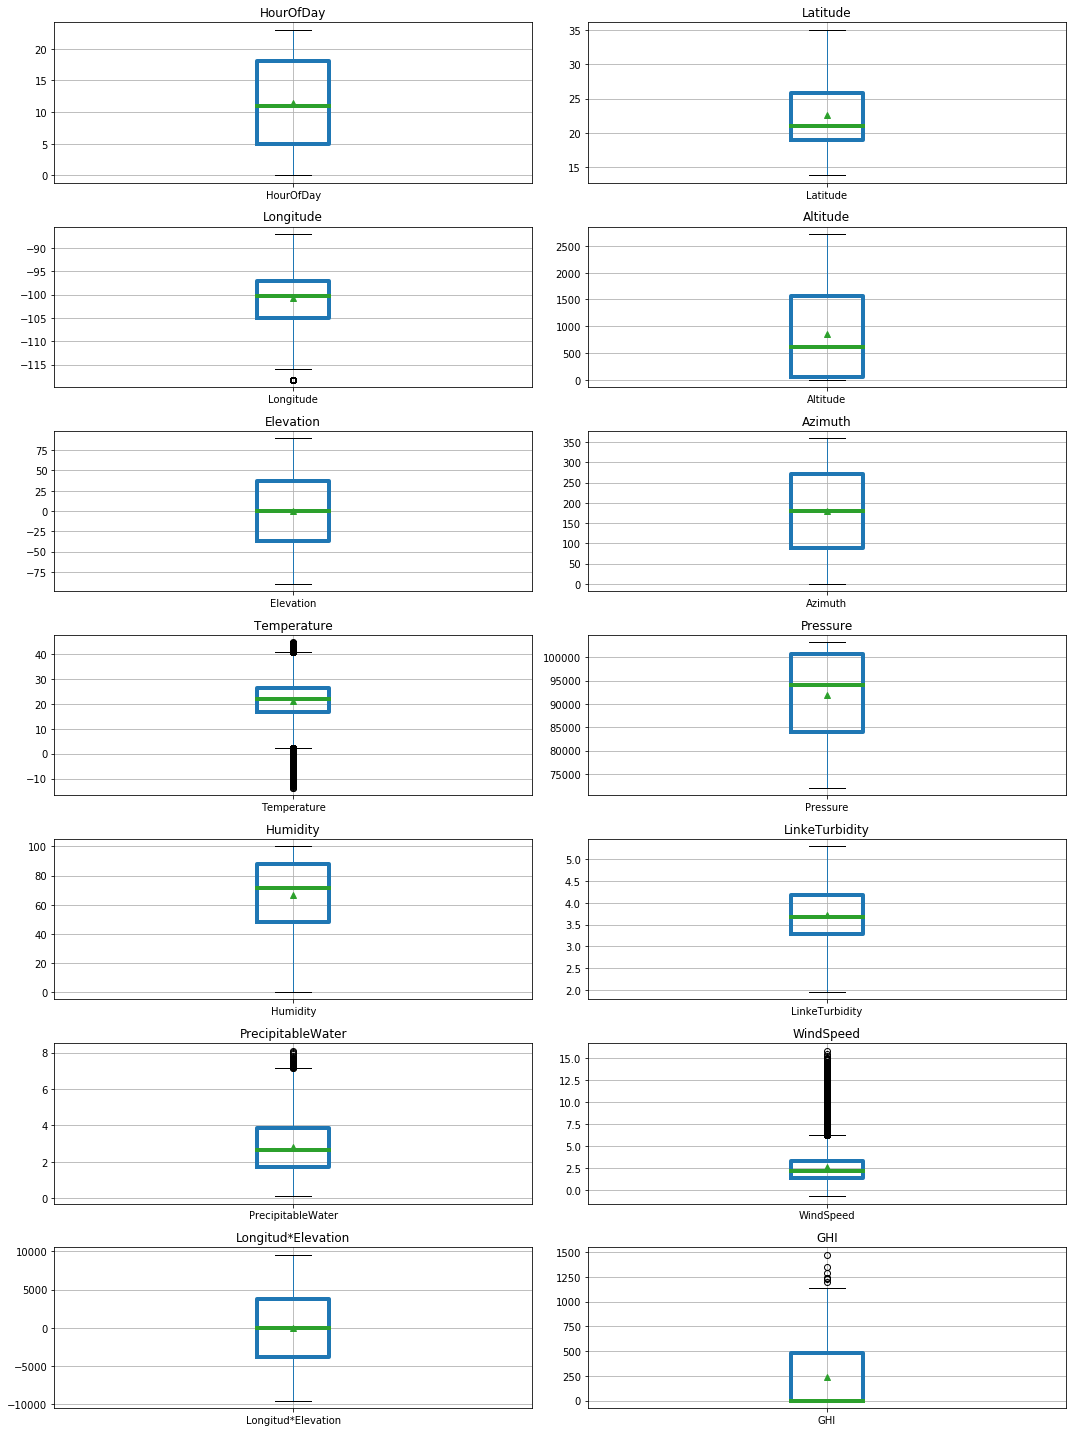

In [12]:
# Atipyc value

boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

plt.rcParams['figure.figsize'] = [15,20]
for i in range(len(df.columns)):
    plt.subplot(7, 2, i+1,)
    df.boxplot(column=df.columns[i],
               showmeans=True, boxprops=boxprops,
               medianprops=medianprops)
               
    plt.title(df.columns[i])
    plt.tight_layout()

In [13]:
# Count atipyc values

dfn = df.copy()

for feature in dfn.columns:
    q75, q25 = np.percentile(dfn[feature], [75, 25])
    iqr = q75 - q25
    sup = q75 + 1.5 * iqr
    inf = q25 - 1.5 * iqr
    mask = ((dfn[feature] > sup) | (dfn[feature] < inf))
    num_atipyc = dfn[feature][mask].count()
    index = dfn[feature][mask].index
    dfn.drop(index, inplace=True)

    print('-'*50)
    print(f'{feature}\nSup:  {sup}\nInf:  {inf}\nAtipycs:  {num_atipyc}')

--------------------------------------------------
HourOfDay
Sup:  37.5
Inf:  -14.5
Atipycs:  0
--------------------------------------------------
Latitude
Sup:  36.18762683868409
Inf:  8.59646320343017
Atipycs:  0
--------------------------------------------------
Longitude
Sup:  -85.10376358032227
Inf:  -117.07919692993164
Atipycs:  8759
--------------------------------------------------
Altitude
Sup:  3828.5
Inf:  -2215.5
Atipycs:  0
--------------------------------------------------
Elevation
Sup:  149.5291700722106
Inf:  -149.20789180267718
Atipycs:  0
--------------------------------------------------
Azimuth
Sup:  542.3133576502274
Inf:  -182.73204763
Atipycs:  0
--------------------------------------------------
Temperature
Sup:  40.72000026702881
Inf:  2.3199987411499023
Atipycs:  4133
--------------------------------------------------
Pressure
Sup:  125554.5
Inf:  59014.5
Atipycs:  0
--------------------------------------------------
Humidity
Sup:  148.43000030517578
Inf:  -1

In [14]:
dfn.shape, df.shape

((515202, 14), (551817, 14))

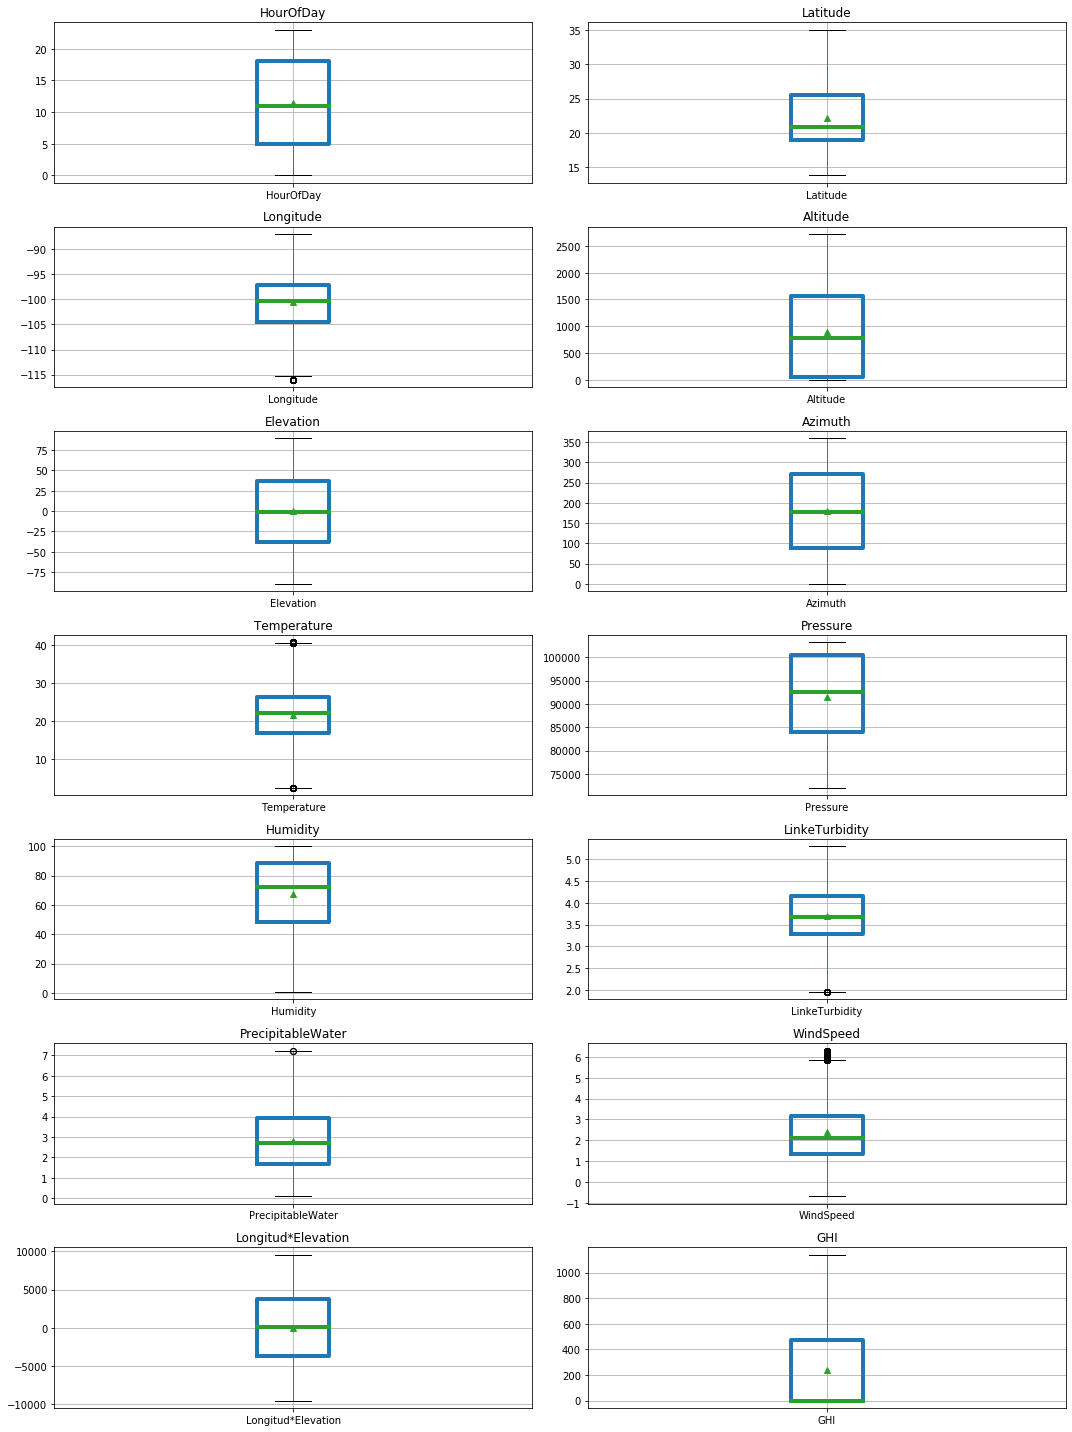

In [16]:
# Atipyc value

boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

for i in range(len(dfn.columns)):
    plt.subplot(7, 2, i+1,)
    dfn.boxplot(column=dfn.columns[i], figsize=(10,15),
               showmeans=True, boxprops=boxprops,
               medianprops=medianprops)
               
    plt.title(dfn.columns[i])
    plt.tight_layout()

In [25]:
# Model test
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
y = dfn.GHI
X = dfn.drop('GHI', axis=1)

In [26]:
# Functions auxiliar
def get_cross_score(model, x, y, scoring='r2', cv=5):
    score = cross_val_score(model, x, y, scoring=scoring, cv=cv)
    return score.mean()

Linear = make_pipeline(PolynomialFeatures(2), LinearRegression())
RidgeReg = make_pipeline(PolynomialFeatures(2), Ridge())
SGDReg = make_pipeline(StandardScaler(),PolynomialFeatures(2),
                       SGDRegressor(loss='huber', learning_rate='optimal'))

In [28]:
# Conjugate all models

models = {
    'LinearRegression' : Linear,
    'Ridge' : RidgeReg,
    'SGD' : SGDReg,
    'RandomForestRegressor' : RandomForestRegressor(max_depth=20),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'XGBoostRegressor' : XGBRegressor(),
}


df_models = pd.DataFrame()


for name, reg in models.items():
    score = get_cross_score(reg, X, y)
    print('='*100)
    print('{}\nR2 score = {:0.5}'.format(name, score))

    df_models[name] = score

LinearRegression
R2 score = 0.88173
Ridge
R2 score = 0.88177
SGD
R2 score = 0.87959
RandomForestRegressor
R2 score = 0.91337
GradientBoostingRegressor
R2 score = 0.91512
XGBoostRegressor
R2 score = 0.91001


In [29]:
X2 = X.drop(['HourOfDay', 'Latitude', 'Longitude', 'Altitude'], axis=1, inplace=True)

models = {
    'RandomForestRegressor' : RandomForestRegressor(max_depth=20),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'XGBoostRegressor' : XGBRegressor(),
}


df_models = pd.DataFrame()


for name, reg in models.items():
    score = get_cross_score(reg, X, y)
    print('='*100)
    print('{}\nR2 score = {:0.5}'.format(name, score))

    df_models[name] = score

RandomForestRegressor
R2 score = 0.91326
GradientBoostingRegressor
R2 score = 0.91474
XGBoostRegressor
R2 score = 0.90923
